## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

import GPy as gpy
import corner as corner

# matplotlib style sheet
plt.style.use('../../neutron_stars_tf/etf/style_1.mplstyle')

np.random.seed(100)

# Load data

In [2]:
name = 'DZ'

if name == 'DZ':
    data = np.loadtxt('DZ_residuals.dat')
elif name == 'LD':
    data = np.loadtxt('LDM_residuals.dat')

## Subset of data ##
# Fraction of data to use for training
trainFrac = 0.1

# Shuffle
shuffled = np.copy(data)
rng = np.random.default_rng()
rng.shuffle(shuffled, axis=0)

# Select random indices of data for training, at random
trainIdx = np.random.choice(shuffled.shape[0], int(round(trainFrac*shuffled.shape[0])), replace=False)

# Create training and testing data sets
train = shuffled[trainIdx,:]
test = np.delete(shuffled, trainIdx, axis=0)

# Save to file the data sets
np.save('trainingData', train)
np.save('testingData', test)

# Input parameters and observations, for training and testing data sets
X = train[:,1:3]
Y = np.atleast_2d(train[:,3]).T
Xtest = test[:,1:3]
Ytest = np.atleast_2d(test[:,3]).T

# Create kernel and GPy model

In [3]:
kernel = gpy.kern.RBF(input_dim=2, ARD=True)
# Fix GP noise parameter to average scale of experimental uncertainty, 0.0235 MeV, as done in Neufcourt et al.
model = gpy.models.GPRegression(X, Y, kernel=kernel, noise_var=0.0235)
_ = model.Gaussian_noise.variance.fix()

In [4]:
# Constrain RBF kernel hyperparameters to reasonable ranges
# model.rbf.variance.constrain_bounded(0., 20.)
# model.rbf.lengthscale.constrain_bounded(0.1, 10.)
model['']

GP_regression.rbf.variance:
Param([1.])
GP_regression.rbf.lengthscale:
Param([1., 1.])
GP_regression.Gaussian_noise.variance:
Param([0.0235])

# Hyperparameter optimisation

In [5]:
_ = model.optimize_restarts()

Optimization restart 1/10, f = 143.48692797940856
Optimization restart 2/10, f = 143.4869279795207
Optimization restart 3/10, f = 143.4869279798983
Optimization restart 4/10, f = 180.69059697583077
Optimization restart 5/10, f = 143.48692797930727
Optimization restart 6/10, f = 143.48692797930454
Optimization restart 7/10, f = 165.52027180641852
Optimization restart 8/10, f = 143.48692797934413
Optimization restart 9/10, f = 143.4869279793009
Optimization restart 10/10, f = 143.48692798360926


In [6]:
# Hyperparameters after optimization
ML_values = model.rbf.param_array
model['']

GP_regression.rbf.variance:
Param([0.26632047])
GP_regression.rbf.lengthscale:
Param([2.0183583 , 1.78599876])
GP_regression.Gaussian_noise.variance:
Param([0.0235])

In [7]:
# model.rbf.lengthscale = model.rbf.lengthscale + 1e-4 * np.random.randn(2)
# model.rbf.variance = model.rbf.variance + 1e-4 * np.random.randn(1)

# HMC inference of kernel hyperparameters
# hmc = gpy.inference.mcmc.HMC(model, stepsize=5e-2)
# samples = hmc.sample(num_samples=10)
# samples[1:,:].mean(axis=0)

# Predictions

In [8]:
# GP predictions at original inputs
mean, cov = model.predict_noiseless(X)

# Save to file
np.savetxt('data/'+name+'_GPPredictionsOriginalInput.dat',
           np.hstack((X, mean, cov)),
           fmt=('\t%d', '\t%d', '\t%.9e', '\t%.9e'),
           header='\tN\tZ\tmeans\t\t\t\tcovs')

In [9]:
"""
Unknown points
Test with Z=30; N=53 to N=100
"""
NNew = np.arange(53, 101, 1, dtype='int')
ZNew = np.repeat(30, len(NNew))
XNew = np.vstack((NNew, ZNew)).T

# GP predictions at unknown points
meanNew, covNew = model.predict_noiseless(XNew)

# Save to file
np.savetxt('data/'+name+'_GPPredictionsNewInput.dat',
           np.hstack((XNew, meanNew, covNew)),
           fmt=('\t%d', '\t%d', '\t%.9e', '\t%.9e'),
           header='\tN\tZ\tmeans\t\t\t\tcovs')

# Plot

In [10]:
difference = mean - Y
print(difference.mean(), difference.std())
print(mean.std())

-3.6336526244317395e-05 0.07553474189465108
0.48994149886968374


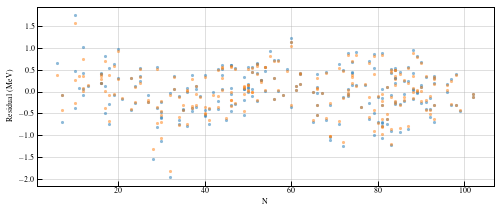

In [11]:
colours = [plt.cm.tab10(i) for i in range(10)]

fig, axs = plt.subplots(1, 1, figsize=(7, 3))

axs.plot(X[:,1], Y,
         alpha=0.5, color=colours[0], fillstyle='full', ls='none', marker='o', mew=0.1)
axs.plot(X[:,1], mean,
         alpha=0.5, color=colours[1], fillstyle='full', ls='none', marker='o', mew=0.1)

axs.set_xlabel('N')
axs.set_ylabel('Residual (MeV)')

fig.tight_layout()
fig.savefig(name+'_residualsDifference.pdf')

# emcee runs

## Load data

In [12]:
runName = 'f50c2e3/'
path = 'vikingRuns/'+runName

originalResiduals = np.loadtxt(path+'DZ_residuals.dat')
train = np.load(path+'trainingData.npy')
test = np.load(path+'testingData.npy')
ML_values = np.loadtxt(path+'ML_values.dat')
emceeSamples = np.loadtxt(path+'flat_samples.dat')

# Input parameters and observations, for training and testing data sets
X = train[:,1:3]
Y = np.atleast_2d(train[:,3]).T
Xtest = test[:,1:3]
Ytest = np.atleast_2d(test[:,3]).T

## Plot train and test data

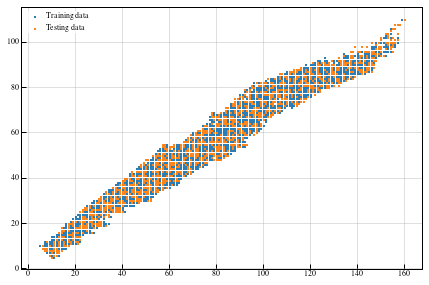

In [13]:
colours = [plt.cm.tab10(i) for i in range(10)]

fig, ax = plt.subplots(1, 1)

ax.scatter(X[:,0], X[:,1], color=colours[0], marker='s', s=1., label='Training data')
ax.scatter(Xtest[:,0], Xtest[:,1], color=colours[1], marker='s', s=1., label='Testing data')

ax.legend()

fig.tight_layout()
fig.savefig(path+'trainTest.pdf')

## Corner plot of GP hyperparameters

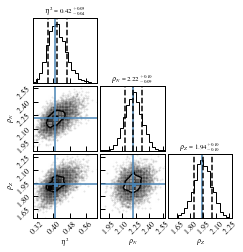

In [14]:
# Input parameters and observations, for training and testing data sets
X = train[:,1:3]
Y = np.atleast_2d(train[:,3]).T
Xtest = test[:,1:3]
Ytest = np.atleast_2d(test[:,3]).T

rcParams['axes.grid'] = False

fig, axs = plt.subplots(3, 3, figsize=(3.4, 3.4))

fig = corner.corner(emceeSamples[:,:],
                    labels=[r'$\eta^2$', r'$\rho_N$', r'$\rho_Z$'],
                    label_kwargs={"fontsize": 7},
                    show_titles=True,
                    title_fmt='.2f',
                    title_kwargs={"fontsize": 7},
                    truths=ML_values,
                    quantiles=[0.16, 0.5, 0.84],
                    max_n_ticks=5,
                    levels=(1-np.exp(-0.5),),
                    fig=fig)

fig.savefig(path+'cornerGPHypPars.pdf')

## Prediction on test data

In [15]:
kernel = gpy.kern.RBF(2, ML_values[0], ML_values[1:], ARD=True)
# Fix GP noise parameter to average scale of experimental uncertainty, 0.0235 MeV, as done in Neufcourt et al.
model = gpy.models.GPRegression(X, Y, kernel=kernel, noise_var=0.0235)
mean, var = model.predict_noiseless(Xtest)

print(originalResiduals[:,3].mean(), originalResiduals[:,3].std())
GPResiduals = Ytest-mean
print(GPResiduals.mean(), GPResiduals.std())

0.002690832231143599 0.5719458916369262
0.0007972854296257608 0.24389272777836432


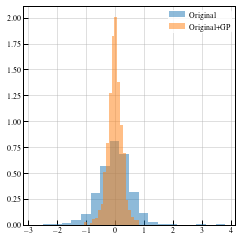

In [16]:
rcParams['axes.grid'] = True

fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))

ax.hist(originalResiduals[:,3], bins=20, density=True,
        color=colours[0],
        label='Original',
        alpha=0.5)
ax.hist(Ytest-mean, bins=20, density=True,
        color=colours[1],
        label='Original+GP',
        alpha=0.5)

ax.legend()

fig.tight_layout()
fig.savefig(path+'residualsHistogram.pdf')